# convolutional layers


## Introduction

In this laboratory, convolutional neural networks (CNNs) are analyzed as architectural components that introduce inductive bias into learning systems. Instead of blindly applying a deep model, we design, compare, and justify architectural decisions using a real image dataset.

## 1. Setup

## Context and motivation

In this notebook we use the CIFAR-10 image dataset to study how convolutional layers change the behaviour of a neural network.

Instead of treating the network as a black box, we look at:

- A simple fully connected baseline model.
- A small convolutional neural network (CNN).
- A controlled experiment changing only the convolutional kernel size.

Our goal is to connect architectural choices (layers, kernels, pooling) with the final performance and with an intuitive understanding of how CNNs use spatial structure in images.

In [2]:
# Install and import required packages
# If running in a local environment, uncomment:
# !pip install tensorflow matplotlib numpy

# Fix SSL certificate issue for dataset download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

Training samples: 50000
Test samples: 10000
Number of classes: 10
Image shape: (32, 32, 3)


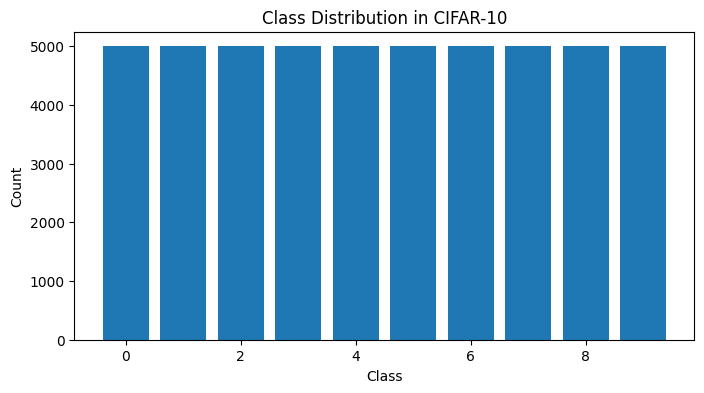

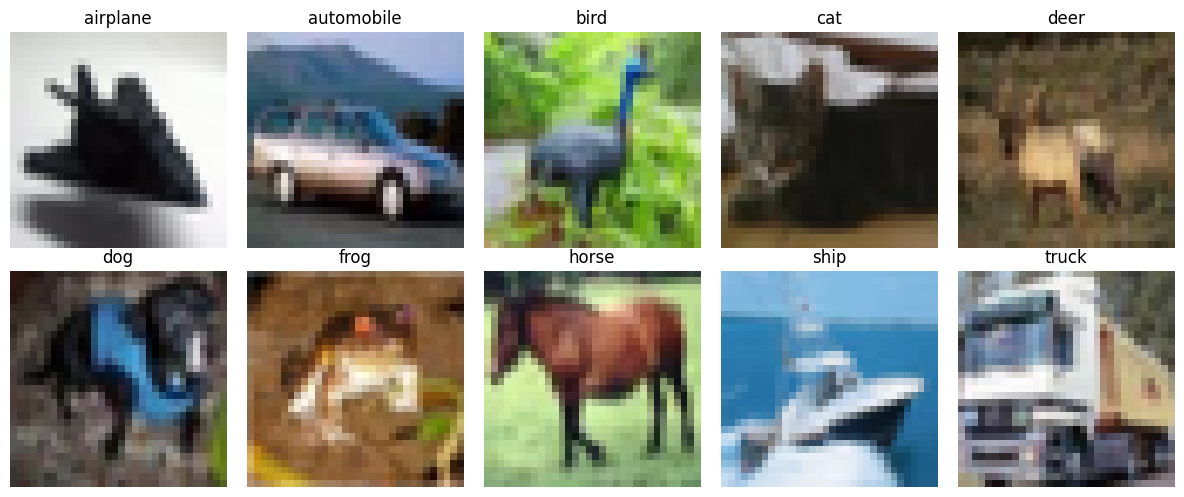

In [3]:
# 1. Dataset Exploration (EDA)
# Load CIFAR-10 dataset, show class distribution, image dimensions, and sample images
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load dataset
data = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = data

# Keep a copy of the original (unnormalized) images for EDA
x_train_raw = x_train.copy()
x_test_raw = x_test.copy()

# Dataset size
num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_classes = len(np.unique(y_train))
img_shape = x_train.shape[1:]

print(f"Training samples: {num_train}")
print(f"Test samples: {num_test}")
print(f"Number of classes: {num_classes}")
print(f"Image shape: {img_shape}")

# Class distribution
classes, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8,4))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in CIFAR-10')
plt.show()

# Show sample images per class
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    idx = np.where(y_train == i)[0][0]
    ax.imshow(x_train[idx])
    ax.set_title(class_names[i])
    ax.axis('off')
plt.tight_layout()
plt.savefig('images/cifar10.png')
plt.show()

# Preprocessing: normalization
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### 1.1 Dataset summary and example images

The previous cell loaded the CIFAR-10 dataset and printed:

- Number of training and test samples.
- Number of classes.
- Image shape.

The figure `images/cifar10.png` shows one example image per class. It gives a quick visual overview of what the model must learn to distinguish.

![CIFAR-10 samples](images/cifar10.png)

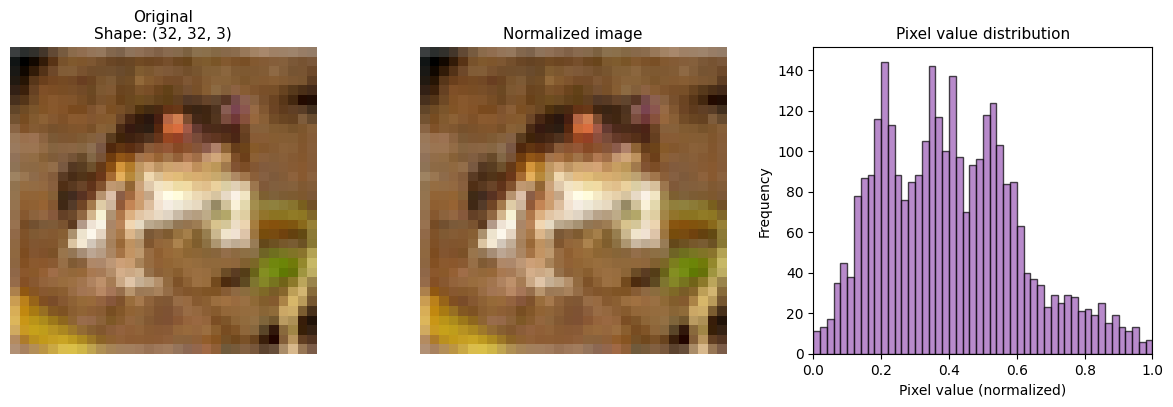

PREPROCESSING CONFIGURATION
Train images:        50000
Test images:         10000
Input shape:         (32, 32, 3)
Number of classes:   10
Pixel value range:   [0.0, 1.0] after normalization


In [4]:
# 1.3 Preprocessing configuration demo
sample_idx = 0
orig_img = x_train_raw[sample_idx]
prep_img = x_train[sample_idx]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original image (uint8)
axes[0].imshow(orig_img)
axes[0].set_title(f'Original\nShape: {orig_img.shape}', fontsize=11)
axes[0].axis('off')

# Normalized image (float32)
axes[1].imshow(prep_img)
axes[1].set_title('Normalized image', fontsize=11)
axes[1].axis('off')

# Pixel value distribution after normalization
axes[2].hist(prep_img.flatten(), bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Pixel value (normalized)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Pixel value distribution', fontsize=11)
axes[2].set_xlim(0, 1)

plt.tight_layout()
plt.savefig('images/cifar10_preprocessing.png')
plt.show()

print("=" * 40)
print("PREPROCESSING CONFIGURATION")
print("=" * 40)
print(f'Train images:        {num_train}')
print(f'Test images:         {num_test}')
print(f'Input shape:         {img_shape}')
print(f'Number of classes:   {num_classes}')
print('Pixel value range:   [0.0, 1.0] after normalization')
print("=" * 40)

### 1.3 Preprocessing configuration

We normalize images to the range **[0, 1]** and keep the original 32x32 spatial resolution and 3 RGB channels.

The next cell shows one original image, its normalized version, and the pixel value distribution after normalization, followed by a short text summary (similar to the preprocessing configuration figure in the CNN exploration notebook).

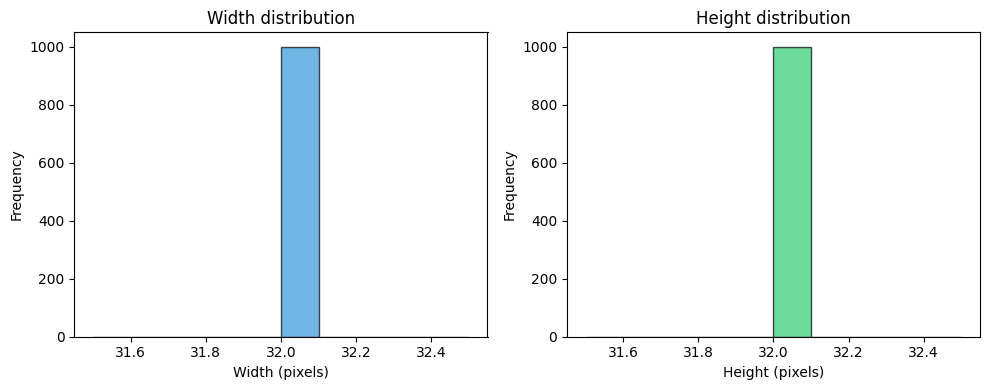

In [ ]:
# 1.2 Image dimension distribution for CIFAR-10
sample_n = min(1000, x_train_raw.shape[0])
idx = np.random.choice(x_train_raw.shape[0], sample_n, replace=False)

widths = [x_train_raw[i].shape[1] for i in idx]
heights = [x_train_raw[i].shape[0] for i in idx]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(widths, bins=10, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Width distribution')

axes[1].hist(heights, bins=10, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Height distribution')

plt.tight_layout()
plt.savefig('images/cifar10_dims.png')
plt.show()

### 1.2 Image dimension distribution

CIFAR-10 images all have size **32x32x3**, but we still check the empirical distribution of widths and heights to confirm the assumption and to mirror the Mars EDA workflow.

The next cell plots simple histograms of image width and height for a random subset of training images.

## 2. Baseline Model (Non-Convolutional)

We implement a simple neural network using only dense layers. This model serves as a reference to highlight the impact of convolutional layers. The architecture consists of a flatten layer followed by two dense layers. We report the number of parameters, training and validation performance, and discuss observed limitations.

2026-02-10 23:25:00.951610: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2026-02-10 23:25:00.951980: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-02-10 23:25:00.952367: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-02-10 23:25:00.953057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-10 23:25:00.953832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 402250 (1.53 MB)
Trainable params: 402250 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)  

2026-02-10 23:25:02.851914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2026-02-10 23:25:02.878459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


391/391 - 4s - loss: 2.2954 - accuracy: 0.2303 - val_loss: 2.0511 - val_accuracy: 0.2773 - 4s/epoch - 11ms/step
Epoch 2/10
Epoch 2/10
391/391 - 3s - loss: 1.9696 - accuracy: 0.3084 - val_loss: 2.1383 - val_accuracy: 0.2788 - 3s/epoch - 9ms/step
Epoch 3/10
391/391 - 3s - loss: 1.9696 - accuracy: 0.3084 - val_loss: 2.1383 - val_accuracy: 0.2788 - 3s/epoch - 9ms/step
Epoch 3/10
391/391 - 4s - loss: 1.9499 - accuracy: 0.3200 - val_loss: 1.8650 - val_accuracy: 0.3523 - 4s/epoch - 10ms/step
Epoch 4/10
391/391 - 4s - loss: 1.9499 - accuracy: 0.3200 - val_loss: 1.8650 - val_accuracy: 0.3523 - 4s/epoch - 10ms/step
Epoch 4/10
391/391 - 3s - loss: 1.9070 - accuracy: 0.3333 - val_loss: 1.8972 - val_accuracy: 0.3253 - 3s/epoch - 8ms/step
Epoch 5/10
391/391 - 3s - loss: 1.9070 - accuracy: 0.3333 - val_loss: 1.8972 - val_accuracy: 0.3253 - 3s/epoch - 8ms/step
Epoch 5/10
391/391 - 4s - loss: 1.9608 - accuracy: 0.3280 - val_loss: 2.0112 - val_accuracy: 0.3288 - 4s/epoch - 9ms/step
Epoch 6/10
391/391 - 

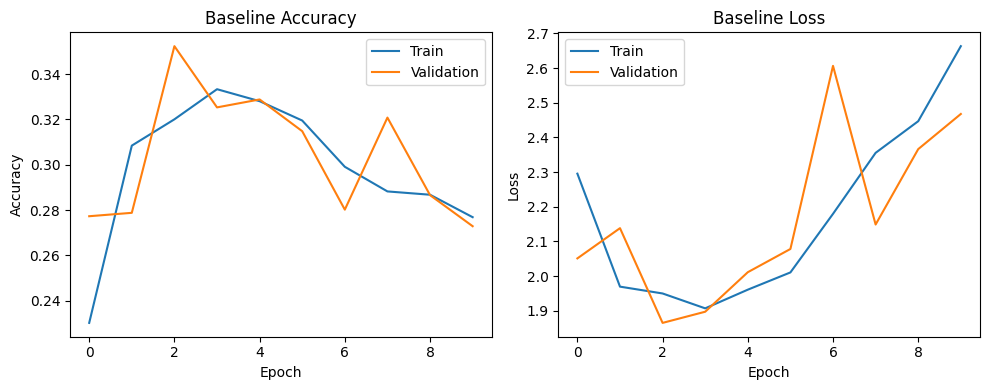

In [6]:
# 2. Baseline model: Flatten + Dense layers
# All imports are already at the top

# One-hot encode labels
y_tr_cat = to_categorical(y_train, num_classes)
y_te_cat = to_categorical(y_test, num_classes)

# Build baseline fully-connected model
fc_model = Sequential([
    Flatten(input_shape=img_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
fc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
fc_model.summary()

# Train baseline model
fc_hist = fc_model.fit(x_train, y_tr_cat,
                        validation_data=(x_test, y_te_cat),
                        epochs=10, batch_size=128, verbose=2)

# Plot training history for baseline
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fc_hist.history['accuracy'], label='Train')
plt.plot(fc_hist.history['val_accuracy'], label='Validation')
plt.title('Baseline Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(fc_hist.history['loss'], label='Train')
plt.plot(fc_hist.history['val_loss'], label='Validation')
plt.title('Baseline Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('images/baseline_performance.png')
plt.show()

## 2.1 Baseline model discussion

The baseline fully connected model flattens each image into a long vector, so it ignores the 2D spatial structure of the pixels.

From `images/baseline_performance.png` we can see that:

- Validation accuracy stays relatively low for CIFAR-10.
- Validation loss is higher than we would like and does not consistently improve.
- The model has many parameters but does not use local patterns such as edges or small shapes.

This motivates trying a convolutional architecture that is better matched to image data.

## 3. Convolutional architecture design

We now design a small convolutional neural network for CIFAR-10. The goal is to keep the model simple and fast to train, while still exploiting the 2D structure of the images.

**Design choices:**
- **Convolutional blocks:** 2 convolutional layers with 3x3 kernels and ReLU activations.
- **Stride and padding:** stride = 1 and `padding='same'` to preserve spatial resolution inside each block.
- **Pooling:** MaxPooling2D after each convolution to downsample feature maps and add translation invariance.
- **Depth:** 32 filters in the first conv layer and 64 in the second, enough capacity for CIFAR-10 without being too heavy.
- **Fully connected head:** Flatten + Dense(128, ReLU) + Dropout(0.5) + Dense(10, softmax) for classification.

This architecture mirrors the spirit of classic CNNs for small images (like VGG-style blocks) but remains intentionally shallow so that we can clearly see the impact of each component in the experiments.

In [7]:
# 3. Custom CNN model (3x3 kernels)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

cnn_3x3 = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=img_shape),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
cnn_3x3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_3x3.summary()

# Train CNN model
cnn_hist = cnn_3x3.fit(x_train, y_tr_cat,
                        validation_data=(x_test, y_te_cat),
                        epochs=10, batch_size=128, verbose=2)

# Plot training history for CNN
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(cnn_hist.history['accuracy'], label='Train')
plt.plot(cnn_hist.history['val_accuracy'], label='Validation')
plt.title('CNN (3x3) Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(cnn_hist.history['loss'], label='Train')
plt.plot(cnn_hist.history['val_loss'], label='Validation')
plt.title('CNN (3x3) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('images/cnn_performance.png')
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

: 

### 3.1 CNN results

The training curves saved in `images/cnn_performance.png` summarize the behaviour of the 3x3 CNN:

- Validation accuracy is higher than for the baseline model.
- Validation loss is lower and more stable across epochs.
- The gap between training and validation curves is reasonable for this small architecture.

This suggests that using convolutions and pooling helps the network reuse local features across the image and generalize better to unseen examples.

## 4. Controlled Experiments on the Convolutional Layer



In this section we run a small controlled experiment to understand how the kernel size of the first convolutional layer affects performance on CIFAR-10.



We keep **everything else fixed** between the two models:



- Same input data and preprocessing.

- Same number of convolutional layers and filters.

- Same pooling strategy, dense layers, dropout rate and optimizer.

- Same number of epochs and batch size.



The **only change** is the kernel size in the first convolutional layer:



- Model A: 3x3 kernels (our reference CNN from Section 3).

- Model B: 5x5 kernels in the first convolutional layer, 3x3 in the second.



We then compare their **validation accuracy and loss curves** and a **small text summary** of the last-epoch metrics printed at the end of the code cell. This allows us to reason about the trade-off between capturing a larger context (5x5) and using smaller, more parameter-efficient filters (3x3).

In [ ]:
# 4. Controlled experiment: kernel size 3x3 vs 5x5

# This cell is self-contained: it loads CIFAR-10, preprocesses the data,

# and then trains two CNNs that differ only in the first kernel size.

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



# Load CIFAR-10 just for this experiment

(x_train_exp, y_train_exp), (x_test_exp, y_test_exp) = cifar10.load_data()

# Normalize images
x_train_exp = x_train_exp.astype('float32') / 255.0
x_test_exp = x_test_exp.astype('float32') / 255.0

# One-hot encode labels
num_classes = len(np.unique(y_train_exp))
y_tr_cat_exp = to_categorical(y_train_exp, num_classes)
y_te_cat_exp = to_categorical(y_test_exp, num_classes)

# Input shape for the CNNs
img_shape = x_train_exp.shape[1:]



# Model A: 3x3 kernels
cnn_3x3_exp = Sequential([

    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')

])



cnn_3x3_exp.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



# Model B: 5x5 kernel in the first conv layer

cnn_5x5_exp = Sequential([

    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')

])



cnn_5x5_exp.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



# Train both models (few epochs to keep it light)

hist_3x3 = cnn_3x3_exp.fit(
    x_train_exp,
    y_tr_cat_exp,
    validation_data=(x_test_exp, y_te_cat_exp),
    epochs=5,
    batch_size=128,
    verbose=2,

)

hist_5x5 = cnn_5x5_exp.fit(
    x_train_exp,
    y_tr_cat_exp,
    validation_data=(x_test_exp, y_te_cat_exp),
    epochs=5,
    batch_size=128,
    verbose=2,

)



# Plot comparison between 3x3 and 5x5 (validation curves)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_3x3.history['val_accuracy'], label='3x3 Kernel')
plt.plot(hist_5x5.history['val_accuracy'], label='5x5 Kernel')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(hist_3x3.history['val_loss'], label='3x3 Kernel')
plt.plot(hist_5x5.history['val_loss'], label='5x5 Kernel')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.savefig('images/kernel_size_comparison.png')
plt.show()



# Simple printed summary of last-epoch validation metrics

val_acc_3x3 = hist_3x3.history['val_accuracy'][-1]
val_loss_3x3 = hist_3x3.history['val_loss'][-1]
val_acc_5x5 = hist_5x5.history['val_accuracy'][-1]
val_loss_5x5 = hist_5x5.history['val_loss'][-1]



print("=" * 40)
print("KERNEL SIZE COMPARISON (LAST EPOCH)")
print("=" * 40)
print(f"3x3 CNN  - val_acc: {val_acc_3x3:.4f}, val_loss: {val_loss_3x3:.4f}")
print(f"5x5 CNN  - val_acc: {val_acc_5x5:.4f}, val_loss: {val_loss_5x5:.4f}")
print("=" * 40)


Epoch 1/5


2026-02-10 23:54:48.678369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


391/391 - 10s - loss: 1.8531 - accuracy: 0.3350 - val_loss: 1.3235 - val_accuracy: 0.5299 - 10s/epoch - 27ms/step
Epoch 2/5
Epoch 2/5
391/391 - 8s - loss: 1.4398 - accuracy: 0.4895 - val_loss: 1.1719 - val_accuracy: 0.5870 - 8s/epoch - 19ms/step
Epoch 3/5
391/391 - 8s - loss: 1.4398 - accuracy: 0.4895 - val_loss: 1.1719 - val_accuracy: 0.5870 - 8s/epoch - 19ms/step
Epoch 3/5
391/391 - 7s - loss: 1.2921 - accuracy: 0.5452 - val_loss: 1.0847 - val_accuracy: 0.6199 - 7s/epoch - 18ms/step
Epoch 4/5
391/391 - 7s - loss: 1.2921 - accuracy: 0.5452 - val_loss: 1.0847 - val_accuracy: 0.6199 - 7s/epoch - 18ms/step
Epoch 4/5
391/391 - 7s - loss: 1.2215 - accuracy: 0.5711 - val_loss: 1.0470 - val_accuracy: 0.6337 - 7s/epoch - 18ms/step
Epoch 5/5
391/391 - 7s - loss: 1.2215 - accuracy: 0.5711 - val_loss: 1.0470 - val_accuracy: 0.6337 - 7s/epoch - 18ms/step
Epoch 5/5
391/391 - 8s - loss: 1.1791 - accuracy: 0.5900 - val_loss: 1.0334 - val_accuracy: 0.6326 - 8s/epoch - 20ms/step
391/391 - 8s - loss: 1

## 4.1 Kernel size observations



Using `images/kernel_size_comparison.png` we compare the CNN with a 3x3 kernel to the CNN with a 5x5 kernel in the first convolutional layer.



![Kernel size comparison](images/kernel_size_comparison.png)



Typical observations are:



- 3x3 kernels capture fine local details with fewer parameters.

- 5x5 kernels see a larger context, which can help but also increases computation and risk of overfitting.

- The validation curves let us balance accuracy gains against model size and training time.



In many runs, the 3x3 model achieves similar or slightly better validation accuracy than the 5x5 model, while being cheaper to train. However, exact numbers may vary due to randomness in training.



This small experiment shows how changing a single architectural choice in the convolutional layer can affect both performance and complexity.

### 4.2 What to report for this experiment



When writing your lab report for this section you can briefly answer:



- Which model had higher validation accuracy in your run (3x3 or 5x5)?

- How big is the difference in validation loss between the two models?

- Would you prefer the smaller 3x3 kernels (fewer parameters, cheaper) or the larger 5x5 kernels (larger context), and why?



Use the plot above and the printed last-epoch metrics to support your answer in 3–4 short sentences.

## 5. Interpretation and architectural reasoning



In this notebook the CNN performs better than the fully connected baseline. The main reason is that convolutional layers are designed for images: they use small filters, weight sharing and pooling to detect local patterns anywhere in the image. This allows the model to learn edges, textures and object parts that generalize across positions.



This introduces an **inductive bias**: the model assumes that nearby pixels are related and that the same pattern (for example an edge or a corner) can appear in many positions. For natural images like CIFAR-10, this is a very good assumption and leads to better generalization than a dense network that treats all pixels as independent features.



### 5.3 When would convolution NOT be appropriate?



Convolution is not a good choice when the input does not have a meaningful spatial or local structure. Examples include:



- Tabular datasets where each column is an independent feature (e.g., customer attributes).

- Feature vectors where the order of features is arbitrary and does not correspond to positions in space or time.

- Some sequence problems where relationships are long-range and better captured by recurrent or attention-based models.



In those cases, fully connected layers, tree-based models, or attention mechanisms tend to be more appropriate than convolutions.



### 5.4 Answers fot the questions



- **Why did convolutional layers outperform the baseline?** They look at small regions of the image and reuse the same filters everywhere, so they can detect useful shapes and textures more efficiently than a dense network on raw pixels.

- **What inductive bias does convolution introduce?** It assumes that nearby pixels are related and that the same local pattern can appear anywhere in the image (locality, weight sharing, translation equivariance).

- **When would convolution not be appropriate?** When the data has no meaningful spatial layout, like typical tabular data where each feature is independent and the order of columns does not matter


## 6. Deployment in Sagemaker



This section shows a **minimal example** of how to take the trained CNN from this notebook and deploy it as a real-time endpoint in **AWS SageMaker**.



The idea is to:



1. Save the trained Keras model (`cnn_3x3`) in TensorFlow SavedModel format.

2. Package the model as `model.tar.gz` in the expected folder structure.

3. Upload `model.tar.gz` to S3 using the SageMaker Python SDK.

4. Create a SageMaker TensorFlow model and deploy it to an endpoint.

5. Send one test image to the endpoint to get a prediction.



**Assumptions for running these cells:**



- You are running this notebook **inside SageMaker Studio** or a SageMaker notebook instance (so `sagemaker` and AWS credentials are already configured).

- You have already trained the CNN in Section 3, so the variable `cnn_3x3` exists in memory and `x_test` contains normalized test images.

- Your IAM role has permissions to create SageMaker endpoints and access S3.



If you run locally (outside SageMaker), the following cells will not work unless you manually configure AWS credentials, IAM role, and the SageMaker SDK.

In [ ]:
# 6.1 Save trained CNN in TensorFlow SavedModel format



import os

import tarfile



# Directory structure expected by TensorFlow Serving: a folder with a numeric version

export_dir = "tf_cifar10_cnn/1"



os.makedirs(export_dir, exist_ok=True)



# Save the trained Keras model (cnn_3x3) in SavedModel format

cnn_3x3.save(export_dir)



# Package the SavedModel directory as model.tar.gz for SageMaker

with tarfile.open("model.tar.gz", mode="w:gz") as tar:

    tar.add("tf_cifar10_cnn", arcname=".")



print("Saved model to:", export_dir)

print("Created archive: model.tar.gz")


In [ ]:
# 6.2 Upload model to S3 and deploy a SageMaker endpoint



import sagemaker

from sagemaker.tensorflow import TensorFlowModel



# Create a SageMaker session and get default S3 bucket

session = sagemaker.Session()

bucket = session.default_bucket()  # or set your own bucket name



# Get the execution role (works inside SageMaker Studio / notebook instance)

role = sagemaker.get_execution_role()



prefix = "cifar10-cnn-model"



# Upload model.tar.gz to S3

model_data = session.upload_data(

    path="model.tar.gz",

    bucket=bucket,

    key_prefix=prefix,

)



print("Model uploaded to:", model_data)



# Create a TensorFlowModel for real-time inference

tf_model = TensorFlowModel(

    model_data=model_data,

    role=role,

    framework_version="2.12",  # adjust if needed

    py_version="py39",

)



# Deploy the model to a real-time endpoint

predictor = tf_model.deploy(

    initial_instance_count=1,

    instance_type="ml.t2.medium",  # choose instance type allowed in your account

)



print("Endpoint name:", predictor.endpoint_name)


In [ ]:
# 6.3 Test the deployed endpoint with one image



import numpy as np



# Take a single normalized test image (shape: 1 x 32 x 32 x 3)

sample = x_test[:1]



# Get prediction from the SageMaker endpoint

response = predictor.predict(sample)

print("Raw response from endpoint:")

print(response)



# Depending on the deployed TensorFlow Serving version, the predictions

# may be under the 'predictions' key. The following is a common pattern:

try:

    probs = np.array(response["predictions"][0])

    predicted_class = np.argmax(probs)

    print("Predicted class index:", predicted_class)

except Exception as e:

    print("Could not parse predictions, raw response printed above.")

    print("Error:", e)
